## E/Gamma HLT efficiency from NanoAOD and NTuples using Tag and Probe.

In this tutorial, we explain the basic usage of this package to perform efficiency measurements of single electron triggers using tag and probe.

To setup this package please follow the README in the package's [Github repository](https://github.com/iasonkrom/egamma-tnp). We will showcase the usage of this package using a few local files but the same principle applies when running on a cluster (like LPC or LXPLUS).

Suppose someone wants to study the efficiency of the trigger path `HLT_Ele30_WPTight_Gsf`.
Let's start by importing some stuff and setting some plotting parameters. The important things here are `Ele30_WPTight_Gsf` and `plot_efficiency`. The rest are just for plotting customization.

In [1]:
import dask
import mplhep as hep
from coffea.dataset_tools import preprocess
from coffea.nanoevents import NanoAODSchema
from matplotlib import pyplot as plt

import egamma_tnp
from egamma_tnp.plot import plot_efficiency
from egamma_tnp.triggers import ElePt_WPTight_Gsf

hep.style.use("CMS")
hep.style.use({"font.size": 16})
hep.style.use({"figure.figsize": (6.4, 4.8)})

NanoAODSchema.error_missing_event_ids = False

egamma_tnp.config.set(
    "ptbins",
    [
        5,
        10,
        12,
        14,
        16,
        18,
        20,
        23,
        26,
        28,
        30,
        32,
        34,
        36,
        38,
        40,
        45,
        50,
        60,
        80,
        100,
        150,
        250,
        400,
    ],
)

The main thing that we are gonna use is the `ElePt_WPTight_Gsf` object. Let's look at its docstrings.

In [2]:
help(ElePt_WPTight_Gsf)

Help on class ElePt_WPTight_Gsf in module egamma_tnp.triggers.elept_wptight_gsf:

class ElePt_WPTight_Gsf(egamma_tnp.triggers.basesingleelectrontrigger.BaseSingleElectronTrigger)
 |  ElePt_WPTight_Gsf(fileset, trigger_pt, *, avoid_ecal_transition_tags=True, avoid_ecal_transition_probes=False, goldenjson=None, extra_filter=None, extra_filter_args=None)
 |  
 |  Method resolution order:
 |      ElePt_WPTight_Gsf
 |      egamma_tnp.triggers.basesingleelectrontrigger.BaseSingleElectronTrigger
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, fileset, trigger_pt, *, avoid_ecal_transition_tags=True, avoid_ecal_transition_probes=False, goldenjson=None, extra_filter=None, extra_filter_args=None)
 |      Tag and Probe efficiency for HLT_ElePt_WPTight_Gsf trigger from NanoAOD.
 |      
 |      Parameters
 |      ----------
 |          fileset : dict
 |              The fileset to calculate the trigger efficiencies for.
 |          trigger_pt : int or float
 |        

In order to initiate such an object we need to know the fileset we're going to run on and the trigger threshold. The latter is 30 in our case. Let's define our fileset.

In [3]:
fileset = {
    "egamma0": {
        "files": {
            "../root_files/Egamma0.root": "Events",
        }
    },
    "egamma1": {
        "files": {
            "../root_files/Egamma1.root": "Events",
        }
    },
    "egamma3": {
        "files": {
            "../tests/samples/DYto2E.root": "Events",
            "../tests/samples/not_a_file.root": "Events",
        }
    },
}

As you can see, we also added a fake file to our fileset. We can use `coffea`'s `preprocess` function to preprocess our dataset.

In [4]:
fileset_available, fileset_updated = preprocess(fileset, maybe_step_size=100_000, skip_bad_files=True)
fileset_available, fileset_updated

({'egamma0': {'files': {'../root_files/Egamma0.root': {'object_path': 'Events',
     'steps': [[0, 100000],
      [100000, 200000],
      [200000, 300000],
      [300000, 400000],
      [400000, 500000],
      [500000, 542854]],
     'uuid': '89580ede-f524-11ed-ab8f-050011acbeef'}},
   'form': None,
   'metadata': None},
  'egamma1': {'files': {'../root_files/Egamma1.root': {'object_path': 'Events',
     'steps': [[0, 100000],
      [100000, 200000],
      [200000, 300000],
      [300000, 400000],
      [400000, 500000],
      [500000, 600000],
      [600000, 608140]],
     'uuid': 'bb19186c-f3a5-11ed-bef3-50f08e80beef'}},
   'form': None,
   'metadata': None},
  'egamma3': {'files': {'../tests/samples/DYto2E.root': {'object_path': 'Events',
     'steps': [[0, 723]],
     'uuid': '59c7ace6-5826-11ee-b8b3-ba00000abeef'}},
   'form': None,
   'metadata': None}},
 {'egamma0': {'files': {'../root_files/Egamma0.root': {'object_path': 'Events',
     'steps': [[0, 100000],
      [100000, 2000

As you can see, preprocessing was able to find the non-existing file and remove it from the fileset.
There is a [tutorial](https://github.com/CoffeaTeam/coffea/blob/master/binder/dataset_discovery.ipynb) in coffea on how to query for such filesets and also how to preprocess them on the spot after querying.

Let's assume however that our non-existing file is a file that is actually there but is going to give us some reading error when opening it. So let's use `fileset` that still contains this file.
Let's initialize our object.

In [5]:
%%time

tag_n_probe = ElePt_WPTight_Gsf(
    fileset,
    30,
    goldenjson="../json/Cert_Collisions2023_366442_370790_Golden.json",
)

tag_n_probe

CPU times: user 17 µs, sys: 23 µs, total: 40 µs
Wall time: 40.1 µs


HLT_Ele30_WPTight_Gsf(Number of files: 4, Golden JSON: ../json/Cert_Collisions2023_366442_370790_Golden.json)

We can ask from this object to give us the $P_T$, $\eta$ and $\phi$ histograms of the probes that pass trigger matching and all the probes. This is done using the `get_tnp_histograms()` method.

In [6]:
%%time

histograms = tag_n_probe.get_tnp_histograms(
    plateau_cut=35,
    eta_regions_pt={
        "barrel": [0.0, 1.4442],
        "endcap": [1.566, 2.5],
    },
)
histograms

CPU times: user 2.83 s, sys: 32.7 ms, total: 2.86 s
Wall time: 2.9 s


/Users/iason/miniforge3/envs/egamma_dev/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:232: RuntimeWarning: Missing event_ids : ['event']
  warnings.warn(
/Users/iason/miniforge3/envs/egamma_dev/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:250: RuntimeWarning: Missing cross-reference target for Electron_jetIdx => Jet
  warnings.warn(
/Users/iason/miniforge3/envs/egamma_dev/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/Users/iason/miniforge3/envs/egamma_dev/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/Users/iason/miniforge3/envs/egamma_dev/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  warnings.warn(
/Users/i

{'egamma0': {'pt': {'barrel': {'passing': Hist(Variable(array([  5.,  10.,  12.,  14.,  16.,  18.,  20.,  23.,  26.,  28.,  30.,
            32.,  34.,  36.,  38.,  40.,  45.,  50.,  60.,  80., 100., 150.,
           250., 400.]), name='hpt_barrel', label='Pt [GeV]'), storage=Double()) # (has staged fills),
    'all': Hist(Variable(array([  5.,  10.,  12.,  14.,  16.,  18.,  20.,  23.,  26.,  28.,  30.,
            32.,  34.,  36.,  38.,  40.,  45.,  50.,  60.,  80., 100., 150.,
           250., 400.]), name='hpt_barrel', label='Pt [GeV]'), storage=Double()) # (has staged fills)},
   'endcap': {'passing': Hist(Variable(array([  5.,  10.,  12.,  14.,  16.,  18.,  20.,  23.,  26.,  28.,  30.,
            32.,  34.,  36.,  38.,  40.,  45.,  50.,  60.,  80., 100., 150.,
           250., 400.]), name='hpt_endcap', label='Pt [GeV]'), storage=Double()) # (has staged fills),
    'all': Hist(Variable(array([  5.,  10.,  12.,  14.,  16.,  18.,  20.,  23.,  26.,  28.,  30.,
            32.,  34.,

Wow, why is the number of probes zero? What happened here? The reason is that those histograms are still task graphs that have to be computed. Let's visualize them.

In [7]:
dask.visualize(histograms, filename="graph.pdf", optimize_graph=True)

To actually perform the computation and get the materialized histograms (may take time!), we can call `.compute()` on each and every single one of them but that's very inefficient so we should do `dask.compute(histograms)`. Luckily, we provide a shortcut for this when using `get_tnp_histograms()` where we can just pass `compute=True` as an argument. Users can also choose whether they want to get a progress bar and can also choose what dask scheduler they want to use. `scheduler=None` will use the default scheduler but other scheduler options are available. More info can be found [here](https://docs.dask.org/en/stable/scheduler-overview.html).

In [8]:
%%time

histograms = tag_n_probe.get_tnp_histograms(
    plateau_cut=35,
    eta_regions_pt={
        "barrel": [0.0, 1.4442],
        "endcap": [1.566, 2.5],
    },
    compute=True,
)

/Users/iason/miniforge3/envs/egamma_dev/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:232: RuntimeWarning: Missing event_ids : ['event']
  warnings.warn(
/Users/iason/miniforge3/envs/egamma_dev/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:250: RuntimeWarning: Missing cross-reference target for Electron_jetIdx => Jet
  warnings.warn(
/Users/iason/miniforge3/envs/egamma_dev/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/Users/iason/miniforge3/envs/egamma_dev/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/Users/iason/miniforge3/envs/egamma_dev/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  warnings.warn(
/Users/i

FileNotFoundError: [Errno 2] No such file or directory: '/Users/iason/fun/egamma_dev/egamma-tnp/notebooks/../tests/samples/not_a_file.root'

And we got a `FileNotFoundError` from our non-existing file. How can we tackle when running over hundreds of files. Well we can pass `uproot_options={"allow_read_errors_with_report": True}`.
This will now return the computed histograms containing only the events that it was able to access AND a report about file access errors.

In [9]:
%%time

histograms, report = tag_n_probe.get_tnp_histograms(
    uproot_options={"allow_read_errors_with_report": True},
    plateau_cut=35,
    eta_regions_pt={
        "barrel": [0.0, 1.4442],
        "endcap": [1.566, 2.5],
    },
    compute=True,
)
histograms, report

/Users/iason/miniforge3/envs/egamma_dev/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:232: RuntimeWarning: Missing event_ids : ['event']
  warnings.warn(
/Users/iason/miniforge3/envs/egamma_dev/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:250: RuntimeWarning: Missing cross-reference target for Electron_jetIdx => Jet
  warnings.warn(
/Users/iason/miniforge3/envs/egamma_dev/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/Users/iason/miniforge3/envs/egamma_dev/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/Users/iason/miniforge3/envs/egamma_dev/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  warnings.warn(
/Users/i

CPU times: user 12.2 s, sys: 1.59 s, total: 13.8 s
Wall time: 7.75 s


({'egamma0': {'pt': {'barrel': {'passing': Hist(Variable(array([  5.,  10.,  12.,  14.,  16.,  18.,  20.,  23.,  26.,  28.,  30.,
             32.,  34.,  36.,  38.,  40.,  45.,  50.,  60.,  80., 100., 150.,
            250., 400.]), name='hpt_barrel', label='Pt [GeV]'), storage=Double()) # Sum: 4859.0 (4860.0 with flow),
     'all': Hist(Variable(array([  5.,  10.,  12.,  14.,  16.,  18.,  20.,  23.,  26.,  28.,  30.,
             32.,  34.,  36.,  38.,  40.,  45.,  50.,  60.,  80., 100., 150.,
            250., 400.]), name='hpt_barrel', label='Pt [GeV]'), storage=Double()) # Sum: 5613.0 (5614.0 with flow)},
    'endcap': {'passing': Hist(Variable(array([  5.,  10.,  12.,  14.,  16.,  18.,  20.,  23.,  26.,  28.,  30.,
             32.,  34.,  36.,  38.,  40.,  45.,  50.,  60.,  80., 100., 150.,
            250., 400.]), name='hpt_endcap', label='Pt [GeV]'), storage=Double()) # Sum: 1805.0,
     'all': Hist(Variable(array([  5.,  10.,  12.,  14.,  16.,  18.,  20.,  23.,  26.,  28.,  

`report` will give us all the info we need about file access errors

In [10]:
report["egamma3"]

<Array [{call_time: None, ...}, {...}] type='2 * {call_time: ?int64, durati...'>

By looking at the result, one can access a histogram like `histograms[dataset][variable][eta_region]`. For instance

In [11]:
histograms["egamma0"]["pt"]["barrel"]

{'passing': Hist(Variable(array([  5.,  10.,  12.,  14.,  16.,  18.,  20.,  23.,  26.,  28.,  30.,
         32.,  34.,  36.,  38.,  40.,  45.,  50.,  60.,  80., 100., 150.,
        250., 400.]), name='hpt_barrel', label='Pt [GeV]'), storage=Double()) # Sum: 4859.0 (4860.0 with flow),
 'all': Hist(Variable(array([  5.,  10.,  12.,  14.,  16.,  18.,  20.,  23.,  26.,  28.,  30.,
         32.,  34.,  36.,  38.,  40.,  45.,  50.,  60.,  80., 100., 150.,
        250., 400.]), name='hpt_barrel', label='Pt [GeV]'), storage=Double()) # Sum: 5613.0 (5614.0 with flow)}

This returns a dictionary with keys `"passing"` and `"all"` that refer to the histograms of passing probes and all probes of the dataset "egamma0" versus $P_T$ in the barrel.

In [12]:
hpt_pass_barrel, hpt_all_barrel = histograms["egamma0"]["pt"]["barrel"].values()
hpt_pass_endcap, hpt_all_endcap = histograms["egamma0"]["pt"]["endcap"].values()
heta_pass, heta_all = histograms["egamma0"]["eta"]["entire"].values()
hphi_pass, hphi_all = histograms["egamma0"]["phi"]["entire"].values()

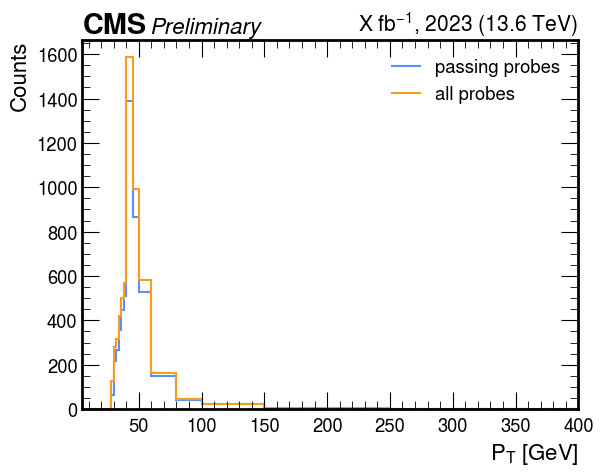

In [13]:
hpt_pass_barrel.plot1d(label="passing probes", flow="none")
hpt_all_barrel.plot1d(label="all probes", flow="none")
plt.xlim(5, 400)
plt.xlabel(r"$P_T$ [GeV]")
plt.ylabel(r"Counts")
plt.legend()
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.show()

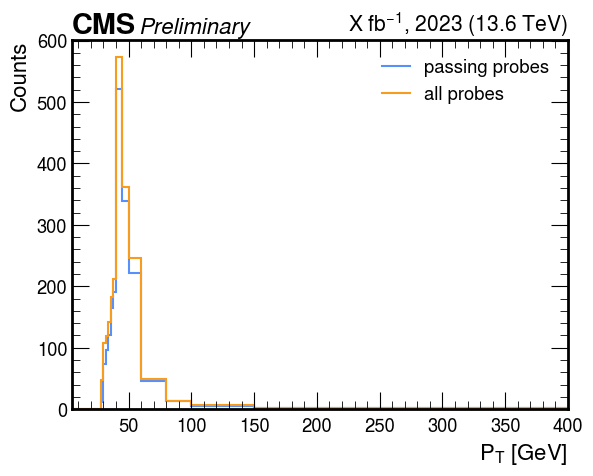

In [14]:
hpt_pass_endcap.plot1d(label="passing probes", flow="none")
hpt_all_endcap.plot1d(label="all probes", flow="none")
plt.xlim(5, 400)
plt.xlabel(r"$P_T$ [GeV]")
plt.ylabel(r"Counts")
plt.legend()
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.show()

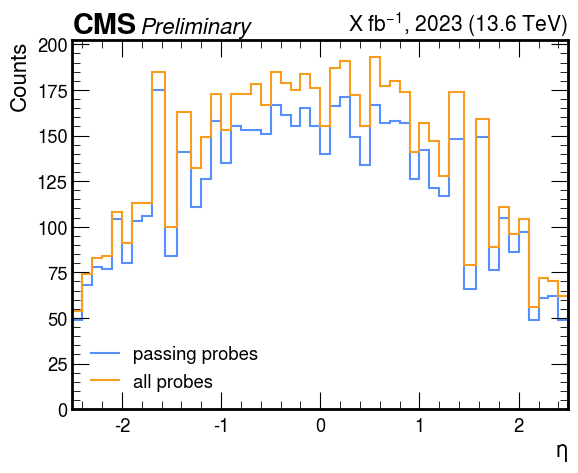

In [15]:
heta_pass.plot1d(label="passing probes", flow="none")
heta_all.plot1d(label="all probes", flow="none")
plt.xlim(-2.5, 2.5)
plt.xlabel(r"$\eta$")
plt.ylabel(r"Counts")
plt.legend()
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.show()

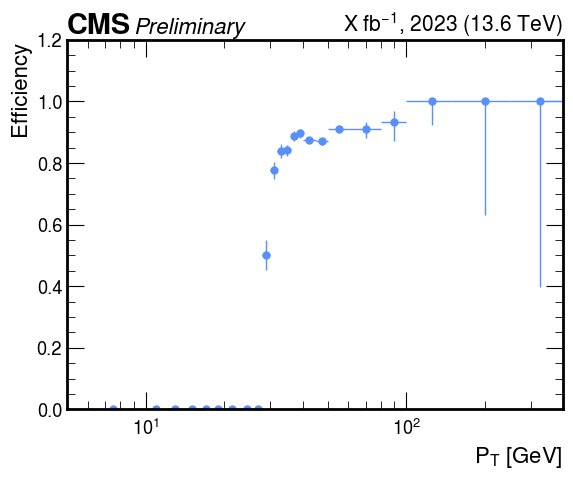

In [16]:
plot_efficiency(hpt_pass_barrel, hpt_all_barrel)
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.xlim(5, 400)
plt.ylim(0, 1.2)
plt.xlabel(r"$P_T$ [GeV]")
plt.ylabel(r"Efficiency")
plt.xscale("log")
plt.show()

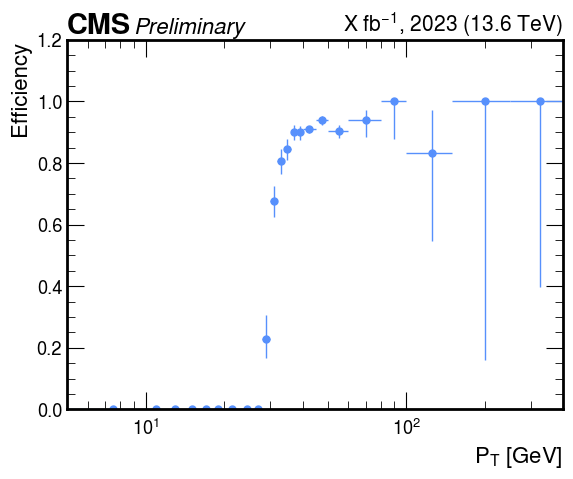

In [17]:
plot_efficiency(hpt_pass_endcap, hpt_all_endcap)
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.xlim(5, 400)
plt.ylim(0, 1.2)
plt.xlabel(r"$P_T$ [GeV]")
plt.ylabel(r"Efficiency")
plt.xscale("log")
plt.show()

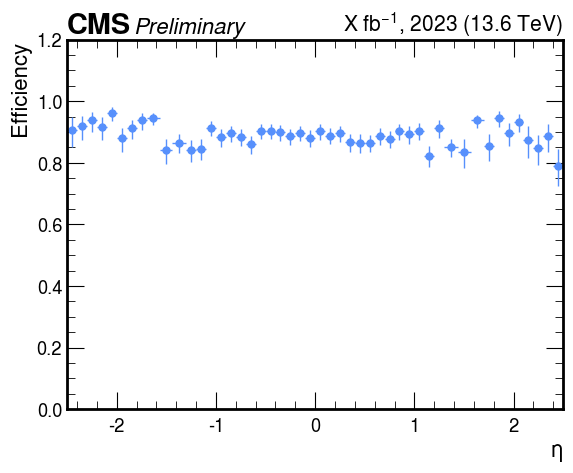

In [18]:
plot_efficiency(heta_pass, heta_all)
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.xlim(-2.5, 2.5)
plt.ylim(0, 1.2)
plt.xlabel(r"$\eta$")
plt.ylabel(r"Efficiency")
plt.show()

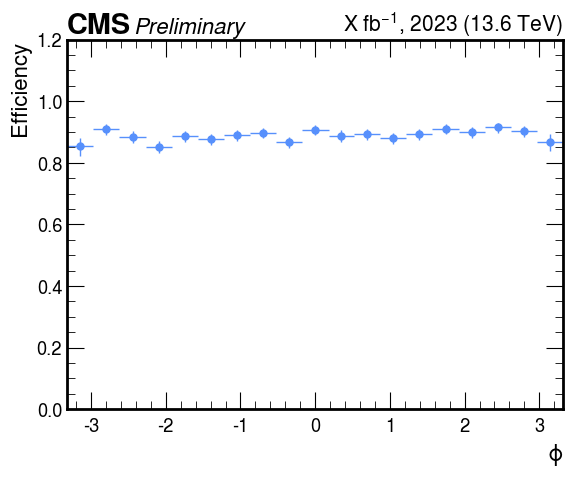

In [19]:
plot_efficiency(hphi_pass, hphi_all)
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.xlim(-3.32, 3.32)
plt.ylim(0, 1.2)
plt.xlabel(r"$\phi$")
plt.ylabel(r"Efficiency")
plt.show()

We also provide the triggers `ElePt_CaloIdVT_GsfTrkIdT` and `ElePt1_ElePt2_CaloIdL_TrackIdL_IsoVL` and `DoubleElePt_CaloIdL_MW` is on the way.

The framework also has the ability to calculate efficiencies from NTuples produced with [EgammaAnalysis-TnPTreeProducer](https://github.com/cms-egamma/EgammaAnalysis-TnPTreeProducer).
In this case we use the `TagNProbeFromNTuples` object

In [20]:
from egamma_tnp.triggers import TagNProbeFromNTuples

Let's look at its docstrings

In [21]:
help(TagNProbeFromNTuples)

Help on class TagNProbeFromNTuples in module egamma_tnp.triggers.ntuple_efficiency:

class TagNProbeFromNTuples(builtins.object)
 |  TagNProbeFromNTuples(fileset, filter, *, trigger_pt=None, goldenjson=None, extra_filter=None, extra_filter_args={})
 |  
 |  Methods defined here:
 |  
 |  __init__(self, fileset, filter, *, trigger_pt=None, goldenjson=None, extra_filter=None, extra_filter_args={})
 |      Tag and Probe efficiency from E/Gamma NTuples
 |      
 |      Parameters
 |      ----------
 |          fileset: dict
 |              The fileset to calculate the trigger efficiencies for.
 |          filter: str
 |              The name of the filter to calculate the efficiencies for.
 |          trigger_pt: int or float, optional
 |              The Pt threshold of the probe electron to calculate efficiencies over that threshold. The default is None.
 |              Should be very slightly below the Pt threshold of the filter.
 |              If it is None, it will attempt to infer i

It appears the only thing different here is that this one takes a filter that we want to calculate the efficiency for that is present in the NTuples.
So again, for `HLT_Ele30_WPTight_Gsf` and a fileset of NTuples we would do. Let's also used a `distributed` `Client` in this case which is how you would run on a cluster with very few modifications.

In [22]:
from distributed import Client

client = Client()

In [23]:
%%time

fileset = {
    "2022": {
        "files": {
            "../tnptuples/data_EGamma_Run2022C.root": "tnpEleTrig/fitter_tree",
            "../tnptuples/data_EGamma_Run2022D.root": "tnpEleTrig/fitter_tree",
            "../tnptuples/data_EGamma_Run2022E.root": "tnpEleTrig/fitter_tree",
            "../tnptuples/data_EGamma_Run2022F.root": "tnpEleTrig/fitter_tree",
            "../tnptuples/data_EGamma_Run2022G.root": "tnpEleTrig/fitter_tree",
        }
    },
    "2023": {
        "files": {
            "../tnptuples/data_EGamma_Run2023B.root": "tnpEleTrig/fitter_tree",
            "../tnptuples/data_EGamma_Run2023C.root": "tnpEleTrig/fitter_tree",
            "../tnptuples/data_EGamma_Run2023D.root": "tnpEleTrig/fitter_tree",
        }
    },
}

tag_n_probe = TagNProbeFromNTuples(
    fileset,
    "passHltEle30WPTightGsf",
)

histograms, report = tag_n_probe.get_tnp_histograms(
    uproot_options={"allow_read_errors_with_report": True},
    plateau_cut=35,
    eta_regions_pt={
        "barrel": [0.0, 1.4442],
        "endcap": [1.566, 2.5],
    },
    compute=True,
)
histograms, report

CPU times: user 1.27 s, sys: 179 ms, total: 1.45 s
Wall time: 14.4 s


({'2022': {'pt': {'barrel': {'passing': Hist(Variable(array([  5.,  10.,  12.,  14.,  16.,  18.,  20.,  23.,  26.,  28.,  30.,
             32.,  34.,  36.,  38.,  40.,  45.,  50.,  60.,  80., 100., 150.,
            250., 400.]), name='hpt_barrel', label='Pt [GeV]'), storage=Double()) # Sum: 7388815.0 (7389363.0 with flow),
     'all': Hist(Variable(array([  5.,  10.,  12.,  14.,  16.,  18.,  20.,  23.,  26.,  28.,  30.,
             32.,  34.,  36.,  38.,  40.,  45.,  50.,  60.,  80., 100., 150.,
            250., 400.]), name='hpt_barrel', label='Pt [GeV]'), storage=Double()) # Sum: 9329895.0 (9330460.0 with flow)},
    'endcap': {'passing': Hist(Variable(array([  5.,  10.,  12.,  14.,  16.,  18.,  20.,  23.,  26.,  28.,  30.,
             32.,  34.,  36.,  38.,  40.,  45.,  50.,  60.,  80., 100., 150.,
            250., 400.]), name='hpt_endcap', label='Pt [GeV]'), storage=Double()) # Sum: 2806082.0 (2806169.0 with flow),
     'all': Hist(Variable(array([  5.,  10.,  12.,  14.,  16

As you can see the workflow is almost identical.

In [24]:
hpt_pass_barrel, hpt_all_barrel = histograms["2023"]["pt"]["barrel"].values()
hpt_pass_endcap, hpt_all_endcap = histograms["2023"]["pt"]["endcap"].values()
heta_pass, heta_all = histograms["2023"]["eta"]["entire"].values()
hphi_pass, hphi_all = histograms["2023"]["phi"]["entire"].values()

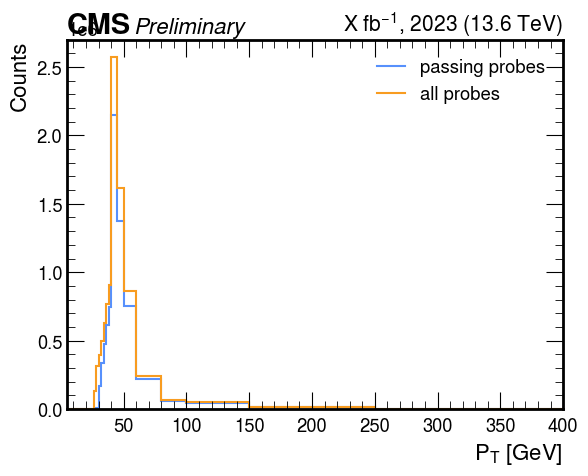

In [25]:
hpt_pass_barrel.plot1d(label="passing probes", flow="none")
hpt_all_barrel.plot1d(label="all probes", flow="none")
plt.xlim(5, 400)
plt.xlabel(r"$P_T$ [GeV]")
plt.ylabel(r"Counts")
plt.legend()
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.show()

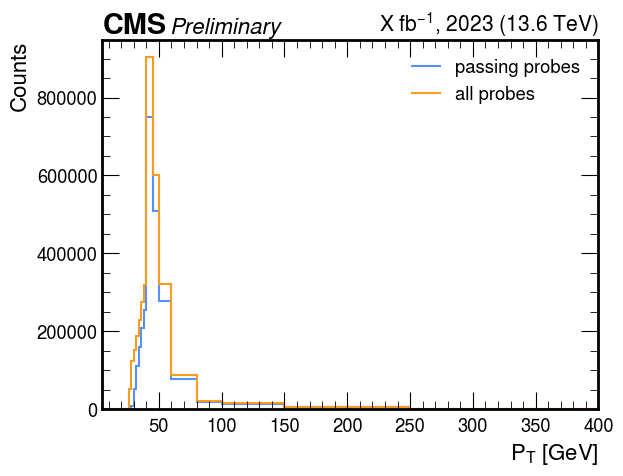

In [26]:
hpt_pass_endcap.plot1d(label="passing probes", flow="none")
hpt_all_endcap.plot1d(label="all probes", flow="none")
plt.xlim(5, 400)
plt.xlabel(r"$P_T$ [GeV]")
plt.ylabel(r"Counts")
plt.legend()
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.show()

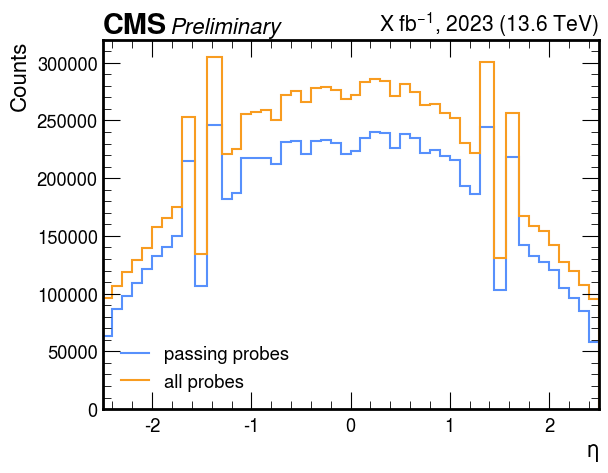

In [27]:
heta_pass.plot1d(label="passing probes", flow="none")
heta_all.plot1d(label="all probes", flow="none")
plt.xlim(-2.5, 2.5)
plt.xlabel(r"$\eta$")
plt.ylabel(r"Counts")
plt.legend()
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.show()

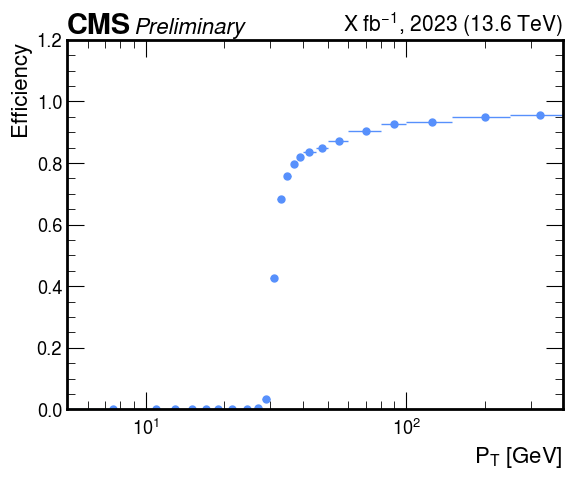

In [28]:
plot_efficiency(hpt_pass_barrel, hpt_all_barrel)
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.xlim(5, 400)
plt.ylim(0, 1.2)
plt.xlabel(r"$P_T$ [GeV]")
plt.ylabel(r"Efficiency")
plt.xscale("log")
plt.show()

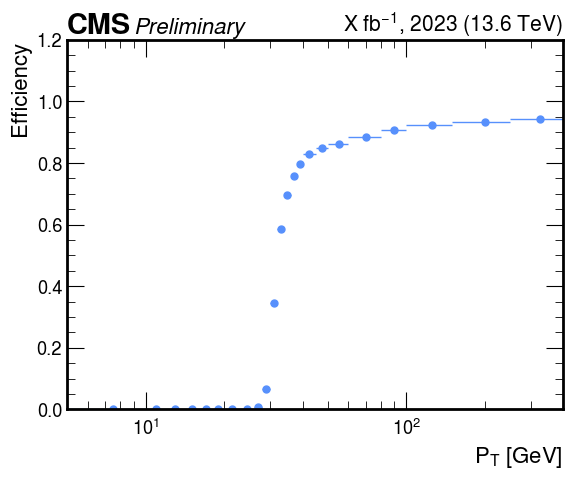

In [29]:
plot_efficiency(hpt_pass_endcap, hpt_all_endcap)
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.xlim(5, 400)
plt.ylim(0, 1.2)
plt.xlabel(r"$P_T$ [GeV]")
plt.ylabel(r"Efficiency")
plt.xscale("log")
plt.show()

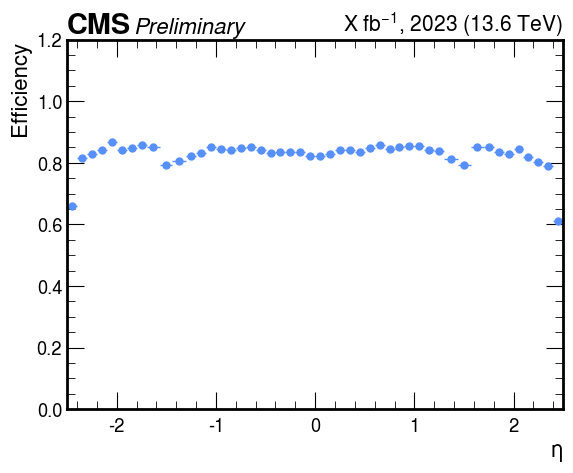

In [30]:
plot_efficiency(heta_pass, heta_all)
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.xlim(-2.5, 2.5)
plt.ylim(0, 1.2)
plt.xlabel(r"$\eta$")
plt.ylabel(r"Efficiency")
plt.show()

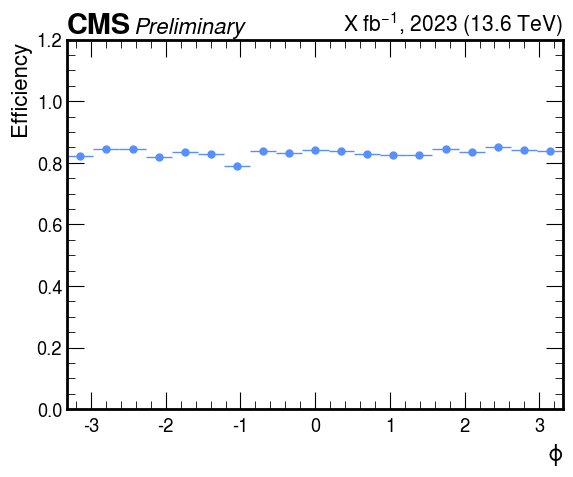

In [31]:
plot_efficiency(hphi_pass, hphi_all)
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.xlim(-3.32, 3.32)
plt.ylim(0, 1.2)
plt.xlabel(r"$\phi$")
plt.ylabel(r"Efficiency")
plt.show()